In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


In [90]:
def add_noise(data, noise_level):
    noise = noise_level * (np.random.randn(*data.shape) + 1j * np.random.randn(*data.shape))
    return data + noise

In [91]:
def compute_SV(data):
    # Compute singular values for all matrices in array1
    sv_arr = np.zeros((0, 4))
    for i, matrix in enumerate(data):
        if not np.isnan(matrix).any():
            U, s, Vt = np.linalg.svd(matrix)
            sv_arr = np.vstack([sv_arr, s])
    return sv_arr


In [92]:
def clustering_alg(sv_arr: np.ndarray, n_clusters = 2):
    

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    #scale and normalise sv_arr to sam scale
    sv_arr_scaled = np.log(1+sv_arr) #- np.mean(np.log(1+sv_arr), axis=0)) / np.std(np.log(1+sv_arr), axis=0)


    kmeans.fit(sv_arr_scaled)
    return kmeans.labels_

In [93]:
# Buggy not working produces naans
def regularize_data(data):
    
    for i in range(len(data)):
        spectral_norm = np.linalg.svd(data[i], compute_uv=False)[0]
        if spectral_norm != 0:
            data[i] = data[i] / spectral_norm
    return data

In [94]:
def regularize_data(data):
    data = data / np.mean(np.abs(data).flatten())
    
    return data

In [95]:
def plot_SV(sv_data, labels = None):
    if labels is None:
        labels = np.zeros(sv_data.shape[0], dtype=int)
        
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axes = axes.ravel()
    for col in range(4):
        ax = axes[col]
        for label in np.unique(labels):
            idx = labels == label
            ax.plot(np.where(idx)[0], sv_data[idx, col], '.', label=f'Cluster {label}', alpha=0.6, markersize=4)
        ax.set_title(f'Singular Value {col+1}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index', fontsize=10)
        ax.set_ylabel('Singular Value', fontsize=10)
        ax.grid(True, which='both', ls='--', alpha=0.3)
        ax.legend(loc='best', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [96]:
def plot_Capacity(capacity_data, labels = None):
    if labels is None:
        labels = np.zeros(capacity_data.shape[0], dtype=int)
    for label in np.unique(labels):
        idx = labels == label
        plt.plot(np.where(idx)[0], (capacity_data[idx]), '.', label=f'Cluster {label}')
    plt.legend()
    plt.show()


In [97]:
def capacity_from_Hmatrix(H: np.ndarray, signal_to_noise_ratio: float) -> float:
    """Calculate channel capacity from channel matrix H.

    Args:
        H (np.ndarray): Channel matrix.
        signal_to_noise_ratio (float): Signal-to-noise ratio.

    Returns:
        float: Estimated channel capacity.
    """
    N_t = 4
    return np.log2(np.linalg.det(np.eye(H.shape[0]) + (signal_to_noise_ratio)/N_t * H @ H.conj().T))

In [98]:
def capacity_Vector(H_matrices):
    capacity_arr = np.zeros(len(H_matrices))
    for i, matrix in enumerate(H_matrices):
        if not np.isnan(matrix).any():
            cap = capacity_from_Hmatrix(H_matrices[i], 10)
            capacity_arr[i] = cap
    return capacity_arr

In [99]:
def create_features(data):
    sv_arr = compute_SV(data)
    


    features = sv_arr  # Use 2nd, 3rd, and 4th singular values as features

    return features

In [100]:
np.array([1, 1e-14]).sum()  # to avoid linter error

np.float64(1.00000000000001)

## Actual clustering

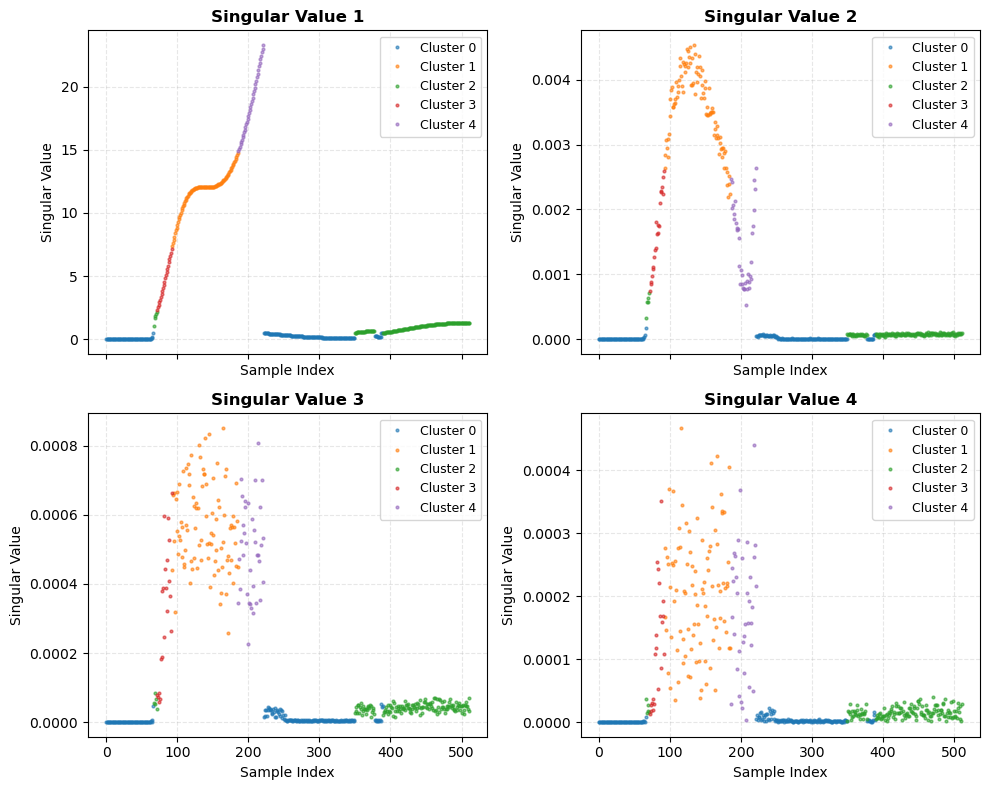

/opt/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/var/folders/m4/118lpvmd05q63v2lh_ldv3xr0000gp/T/ipykernel_34080/3980399525.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  capacity_arr[i] = cap


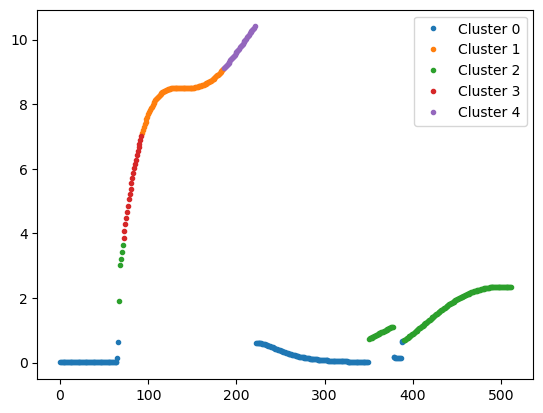

In [101]:
data = np.load('0_5_60.npz')
H_matrices = data['matrices']


#H_matrices = H_matrices[128*512:129*512]

H_matrices = H_matrices[:512]
H_matrices = H_matrices[~np.isnan(H_matrices).any(axis=(1,2))]
H_matrices = regularize_data(H_matrices)
H_matrices = add_noise(H_matrices, noise_level=0)
sv_data = compute_SV(H_matrices)
labels = clustering_alg(sv_data, n_clusters=5)
plot_SV(sv_data, labels)
capacity_data = capacity_Vector(H_matrices)
plot_Capacity(capacity_data, labels)




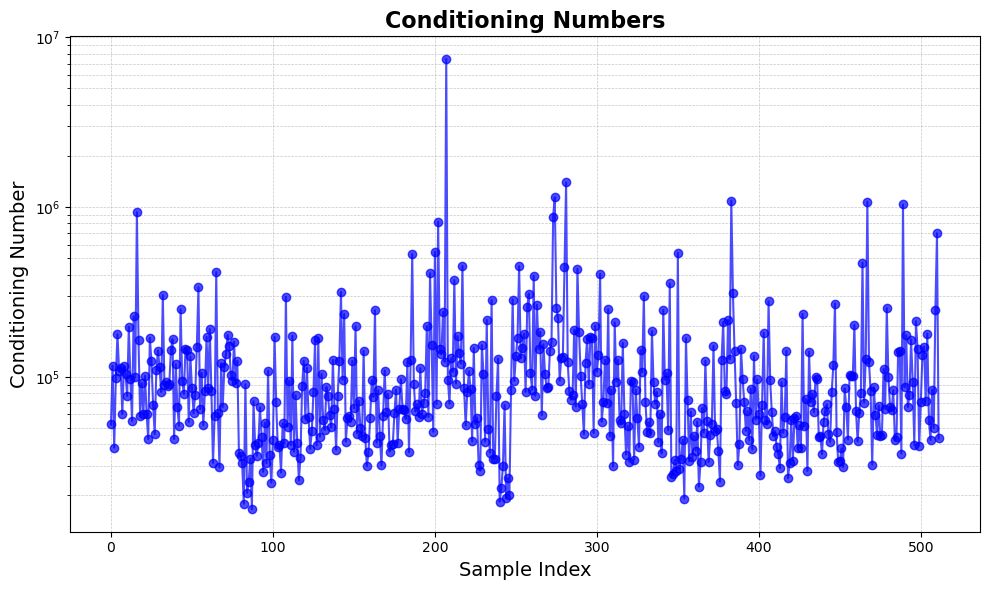

In [102]:
# Plotting capacity_data
plt.figure(figsize=(10, 6))
plt.semilogy(sv_data[:, 0] / sv_data[:, -1], marker='o', linestyle='-', color='b', alpha=0.7)
plt.title('Conditioning Numbers', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Conditioning Number', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


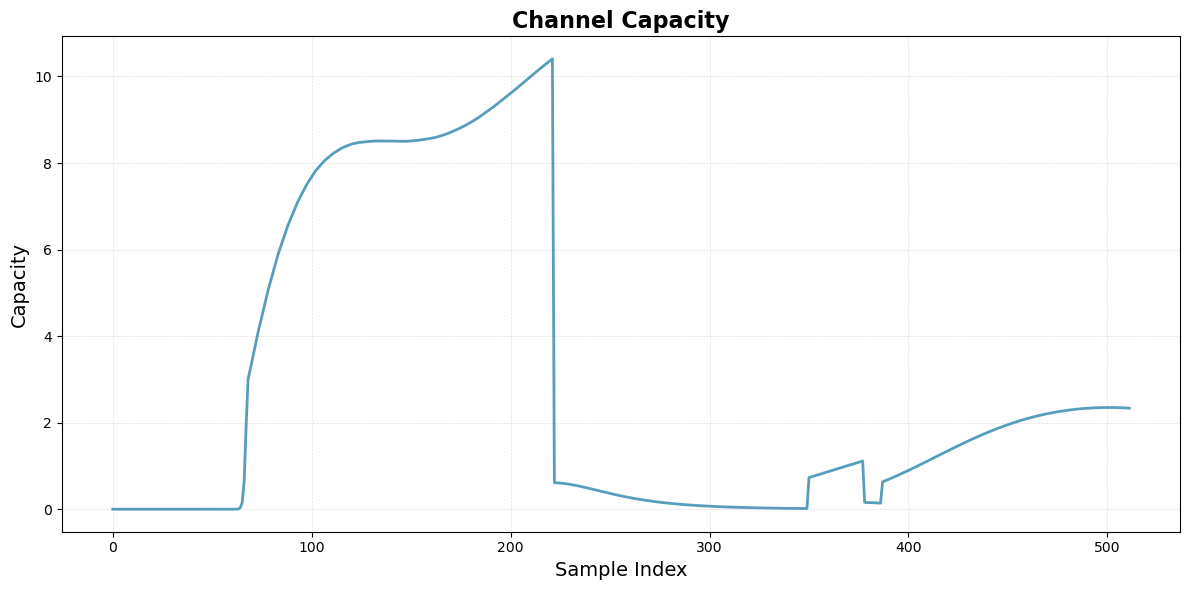

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(capacity_data, linewidth=2, color='#2E86AB', alpha=0.8)
plt.title('Channel Capacity', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Capacity', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()

In [104]:
coords = data['coords']
#coords = np.vstack([coords[:512], coords[128*512:129*512], coords[256*512:257*512], coords[384*512:385*512]]) * 2
coords = coords[:512*512] * 2

H_matrices = data['matrices']
H_matrices[np.isnan(H_matrices).any(axis=(1,2))] = np.zeros_like(H_matrices[np.isnan(H_matrices).any(axis=(1,2))])
#H_matrices = np.vstack([H_matrices[:512], H_matrices[128*512:129*512], H_matrices[256*512:257*512], H_matrices[384*512:385*512]])
H_matrices = H_matrices[:512*512]
H_matrices = regularize_data(H_matrices)
H_matrices = add_noise(H_matrices, noise_level=0)
capacity_data = capacity_Vector(H_matrices)

/var/folders/m4/118lpvmd05q63v2lh_ldv3xr0000gp/T/ipykernel_34080/3980399525.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  capacity_arr[i] = cap


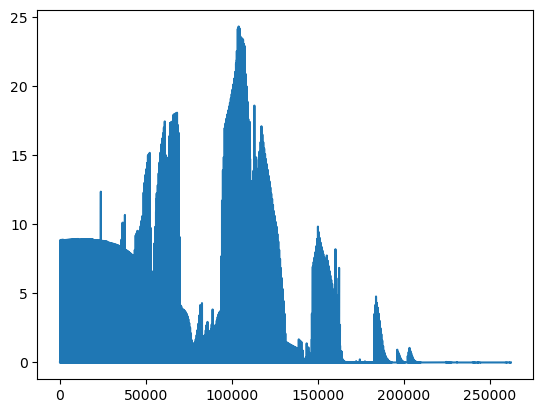

In [105]:
plt.plot(capacity_data)

Text(0.5, 1.0, 'Capacity Overlaid on City Image')

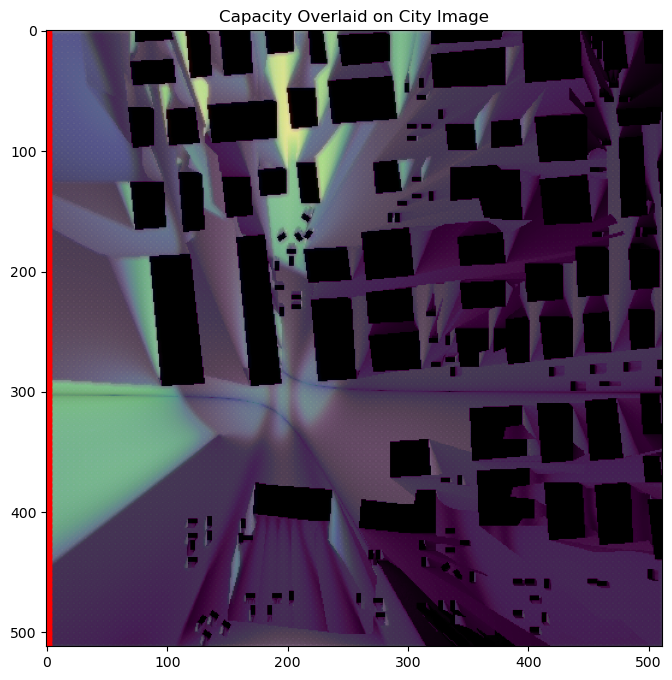

In [142]:
from PIL import Image

# Load the image
img = Image.open('images/city.png')

#plot image with coords overlaid
plt.figure(figsize=(10, 8))
plt.imshow(img)
sc = plt.scatter(coords[:, 0], coords[::-1, 1], cmap='viridis', c=np.log(1 + capacity_data), alpha=0.01, s=20)
sc = plt.scatter(coords[:512, 0], coords[:512, 1], c='red', alpha=1, s=20)
plt.title('Capacity Overlaid on City Image')

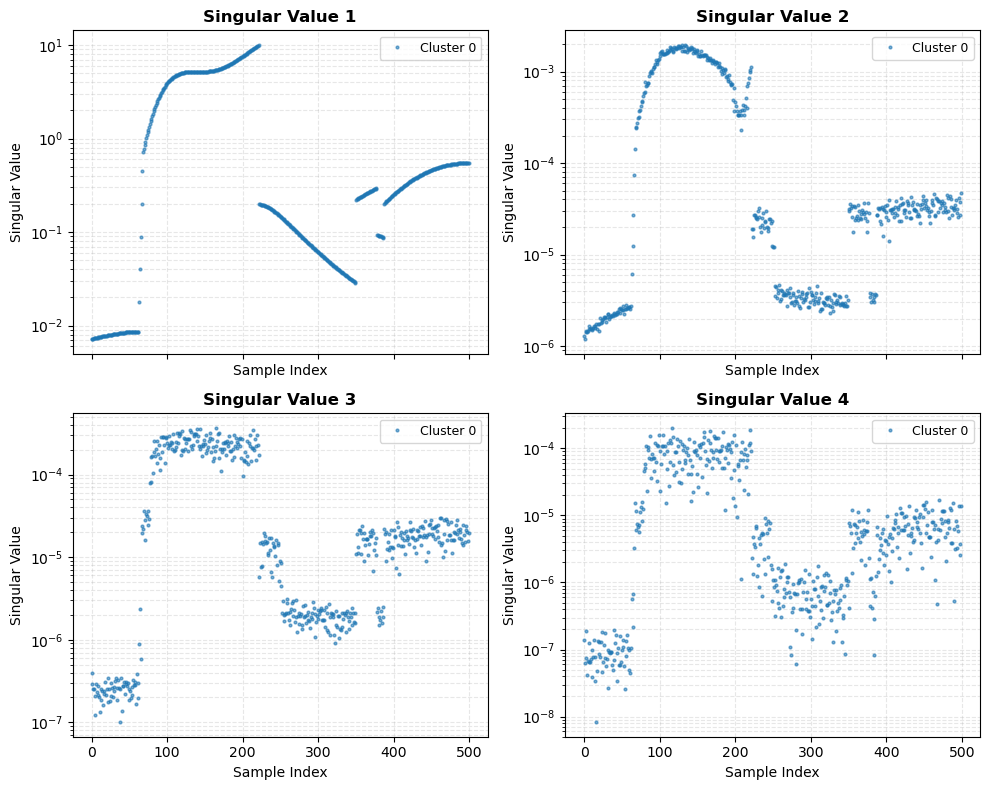

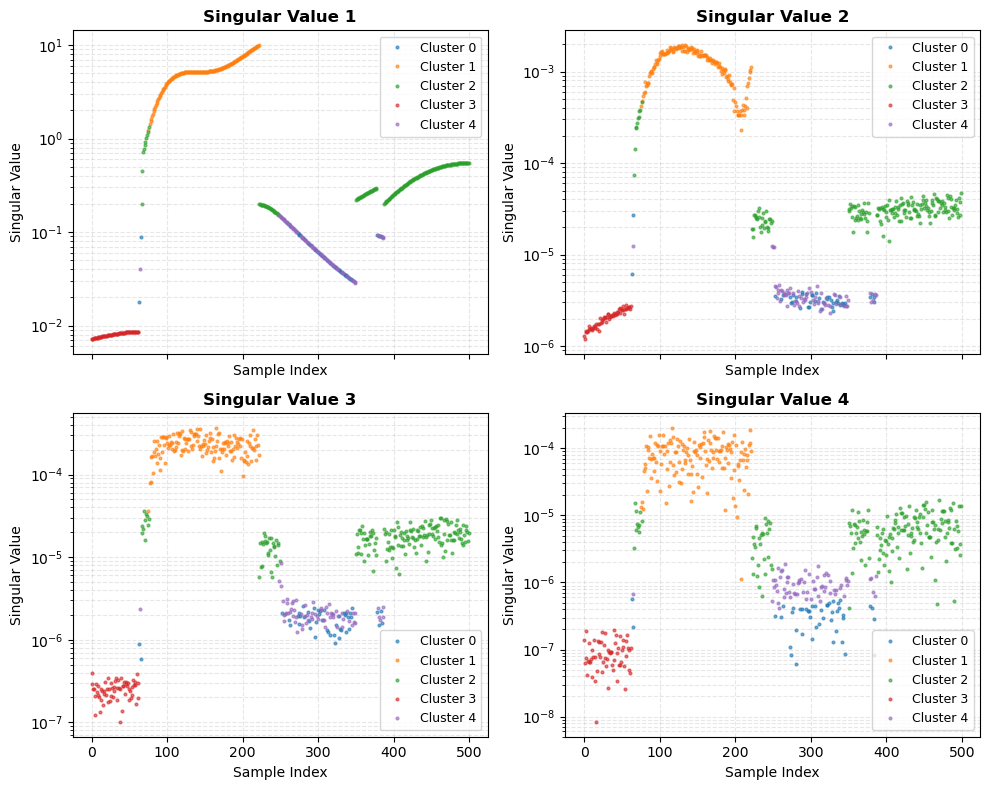

/var/folders/m4/118lpvmd05q63v2lh_ldv3xr0000gp/T/ipykernel_27683/3980399525.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  capacity_arr[i] = cap


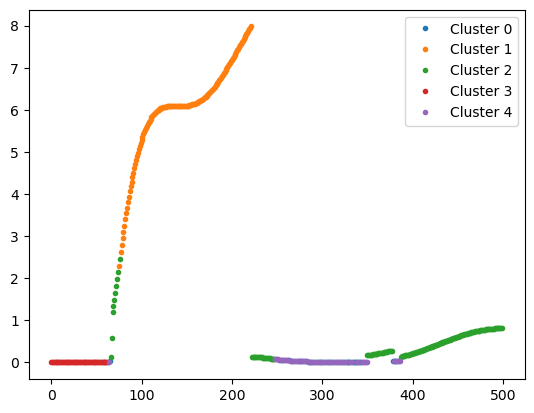

In [ ]:
# Load the NPZ file
data = np.load('0_5_60.npz')

matrices = data['matrices']
matrices = matrices[~np.isnan(matrices).any(axis=(1,2))]

matrices = regularize_data(matrices)


matrices = matrices[:500]  # Use only the first 500 samples for testing

sv_arr = compute_SV(matrices)

plot_SV(sv_arr)

labels, centers = clustering_alg(matrices, n_clusters=5)
plot_SV(sv_arr, labels)

capacities = capacity_Vector(matrices)
plot_Capacity(capacities, labels)

In [133]:
features = create_features(H_matrices)
n_clusters = 5

labels = clustering_alg(features, n_clusters=n_clusters)
labels += n_clusters

Text(0.5, 1.0, 'Clusters Overlaid on City Image')

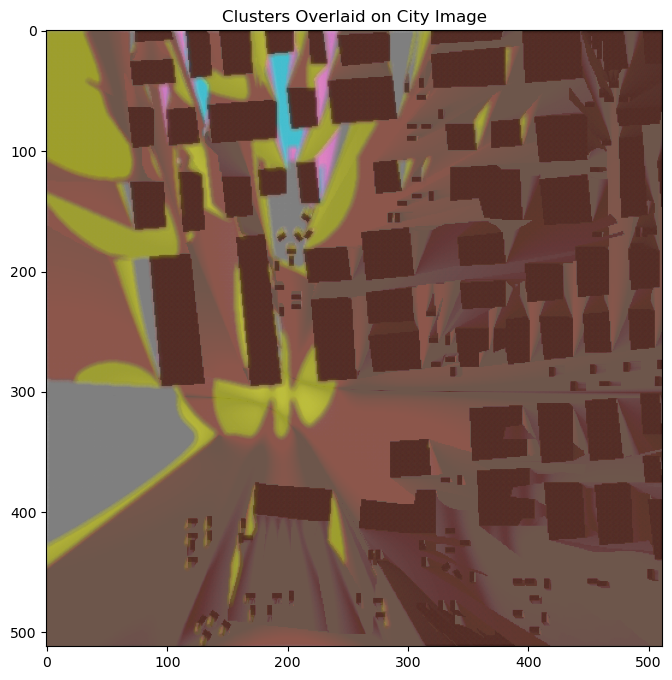

In [134]:
from matplotlib.colors import ListedColormap
# Load the image
img =Image.open('images/city.png')

cmap1 = plt.get_cmap('tab10').colors
cmap_top = ListedColormap(cmap1[5:])

#plot image with coords overlaid
plt.figure(figsize=(10, 8))
plt.imshow(img)
sc = plt.scatter(coords[:, 0], coords[::-1, 1], cmap = cmap_top, c=labels.astype(int), alpha=0.03, s=20)

plt.title('Clusters Overlaid on City Image')

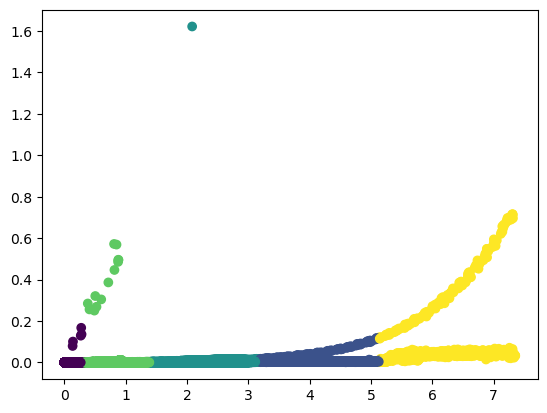

In [135]:
sv_data = compute_SV(H_matrices)
plt.scatter(np.log(1 + sv_data[:, 0]), np.log(1 + sv_data[:, 1]), c = labels)


In [136]:
zero_label = np.where(labels == 5)
features2 = features[zero_label]
labels2 = clustering_alg(features2, n_clusters=n_clusters)

labels[zero_label] = labels2




Text(0.5, 1.0, 'Clusters Overlaid on City Image')

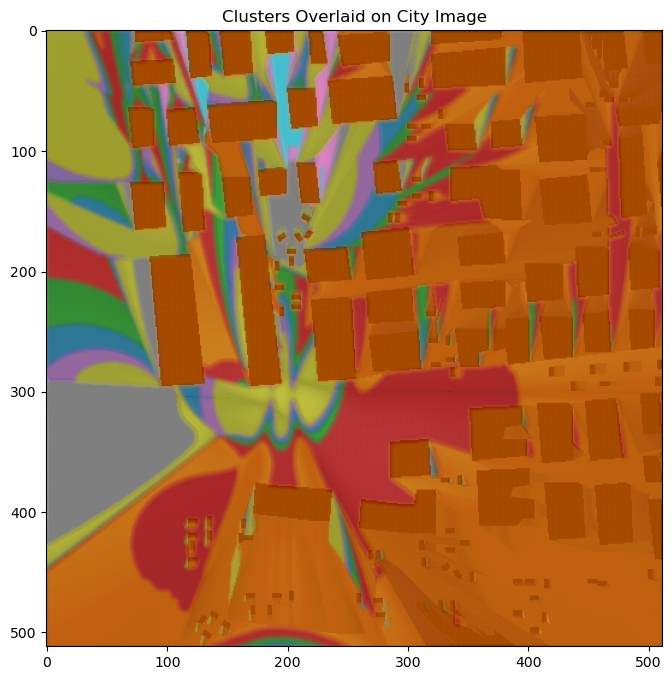

In [139]:
# Load the image
img = Image.open('images/city.png')

cmap1 = plt.get_cmap('tab10').colors
cmap_top = ListedColormap(cmap1[:10])
#plot image with coords overlaid
plt.figure(figsize=(10, 8))
plt.imshow(img)
sc = plt.scatter(coords[:, 0], coords[::-1, 1],cmap = cmap_top, c=labels, alpha=0.03, s=20)
plt.title('Clusters Overlaid on City Image')

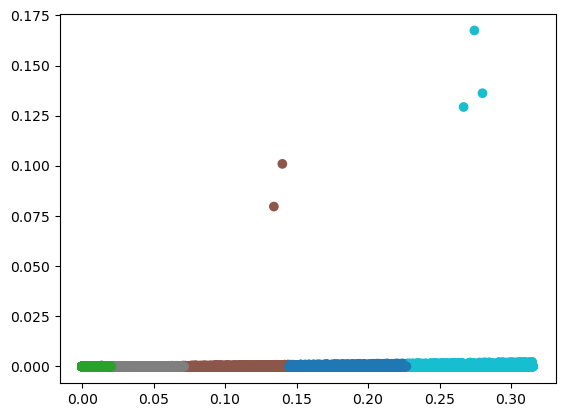

In [138]:
plt.scatter(np.log(1 + sv_data[:, 0])[zero_label], np.log(1 + sv_data[:, 1])[zero_label],cmap= 'tab10', c = labels[zero_label])